In [1]:

import seaborn as sns


In [2]:
import json
import os
import re

import pandas as pd

from modelforge.datasets.datasets import (
    anomaly_dataset,
    heating_dataset,
    immoscout_house_price_dataset,
    weather_dataset_probabilistic_regression,
)

datasets = ["anomaly", "heating", "house_price", "weather_probabilistic"]
dataset_sizes = [
    anomaly_dataset("score", "../../data/processed/anomaly_models").size,
    heating_dataset("../../data/processed/heating_models/data").size,
    immoscout_house_price_dataset(
        "../../data/processed/immoscout24_models/house_price/data"
    ).size,
    weather_dataset_probabilistic_regression(
        "../../data/processed/weather_models/prob/data"
    ).size,
]
datasets_retraining = [f"{dataset}_retraining" for dataset in datasets]
datasets_representative = [f"{dataset}_representative" for dataset in datasets]
datasets = datasets_representative + datasets_retraining
dataset_sizes = dataset_sizes * 2
losses = ["roc_auc", "mae", "mape", "crps"]
losses = losses * 2
losses_maximize = [True, False, False, False]
losses_maximize = losses_maximize * 2


def read_experiment_results(experiment: str, experiment_date: str):

    pipeline_regex = re.compile(r"^(.*)_\d{4}-\d{2}-\d{2}-\d{2}:\d{2}$")

    rows = []
    for dataset, loss, loss_maximize in zip(datasets, losses, losses_maximize):
        pipeline_groups = [
            dir
            for dir in os.listdir(f"../../data/results/{experiment}/{dataset}")
            if os.path.isdir(f"../../data/results/{experiment}/{dataset}/{dir}")
            if experiment_date in dir
        ]
        pipeline_groups_clean = [
            pipeline_regex.match(pipeline).group(1).replace("_uniform", "")
            for pipeline in pipeline_groups
        ]
        for pipeline_group, pipeline_group_clean in zip(
                pipeline_groups, pipeline_groups_clean
        ):
            pipelines = [
                dir
                for dir in os.listdir(
                    f"../../data/results/{experiment}/{dataset}/{pipeline_group}"
                )
                if os.path.isdir(
                    f"../../data/results/{experiment}/{dataset}/{pipeline_group}/{dir}"
                )
            ]
            for pipeline in pipelines:
                cluster_amounts = os.listdir(
                    f"../../data/results/{experiment}/{dataset}/{pipeline_group}/{pipeline}"
                )
                for cluster_amount in cluster_amounts:
                    with open(
                            f"../../data/results/{experiment}/{dataset}/{pipeline_group}/{pipeline}/{cluster_amount}/params.json"
                    ) as f:
                        params = json.load(f)
                        num_cluster = params[
                            "modelclusterer__cluster_mixin__n_clusters"
                        ]
                    with open(
                            f"../../data/results/{experiment}/{dataset}/{pipeline_group}/{pipeline}/{cluster_amount}/scores.json"
                    ) as f:
                        try:
                            scores = json.load(f)
                            rows.append(
                                {
                                    "dataset": dataset,
                                    "loss": loss,
                                    "pipeline": pipeline,
                                    "pipeline_group": pipeline_group_clean,
                                    **scores,
                                    "num_clusters": int(num_cluster),
                                }
                            )
                        except json.JSONDecodeError:
                            print(
                                f"Could not load scores for {dataset}/{pipeline_group}/{pipeline}/{cluster_amount}"
                            )
                            print(f)
                rows.append(
                    {
                        "dataset": dataset,
                        "pipeline": pipeline,
                        "pipeline_group": pipeline_group_clean,
                        **scores,
                    }
                )
    return pd.DataFrame(rows), pipeline_groups, pipeline_groups_clean


In [3]:
experiment_date = "2025-04-01-15:28"
experiment = "consolidation_strategy"
df, pipeline_groups, pipeline_groups_clean = read_experiment_results(experiment, experiment_date)

In [4]:
df

,dataset,loss,pipeline,pipeline_group,cluster_loss,model_loss,cluster_var,model_var,num_clusters
0,anomaly_representative,roc_auc,pairwise_loss_max_target_median_10,pairwise_loss,0.576203,0.605849,0.009673,0.029264,135
1,anomaly_representative,roc_auc,pairwise_loss_max_target_median_10,pairwise_loss,0.557112,0.605849,0.008941,0.029264,132
2,anomaly_representative,roc_auc,pairwise_loss_max_target_median_10,pairwise_loss,0.551012,0.605849,0.007469,0.029264,92
3,anomaly_representative,roc_auc,pairwise_loss_max_target_median_10,pairwise_loss,0.568887,0.605849,0.009216,0.029264,103
4,anomaly_representative,roc_auc,pairwise_loss_max_target_median_10,pairwise_loss,0.531000,0.605849,0.006041,0.029264,57
...,...,...,...,...,...,...,...,...,...
1195,weather_probabilistic_retraining,crps,pairwise_loss_random_10,pairwise_loss,0.820530,0.854452,0.007394,0.014164,47
1196,weather_probabilistic_retraining,crps,pairwise_loss_random_10,pairwise_loss,0.916571,0.854452,0.000004,0.014164,2
1197,weather_probabilistic_retraining,crps,pairwise_loss_random_10,pairwise_loss,0.833339,0.854452,0.003257,0.014164,14
1198,weather_probabilistic_retraining,crps,pairwise_loss_random_10,pairwise_loss,0.824958,0.854452,0.004508,0.014164,22


<Axes: xlabel='num_clusters', ylabel='cluster_loss'>

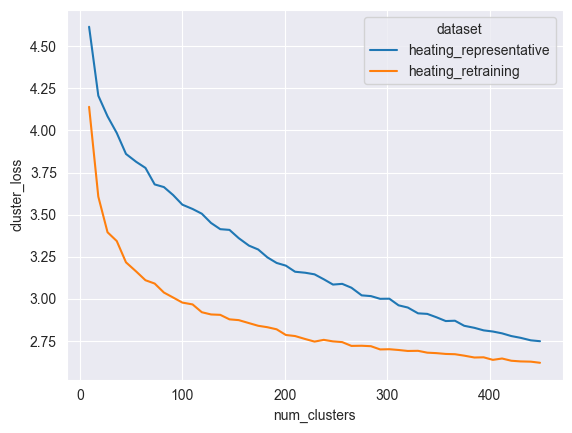

In [5]:
df_heating = df[(df["dataset"].str.contains("heating")) & (df["pipeline"] == "pairwise_loss_max_target_median_10")]
sns.lineplot(df_heating, x="num_clusters", y="cluster_loss", hue="dataset")

In [6]:
df_heating = df[df["dataset"].str.contains("heating")]
df_heating

,dataset,loss,pipeline,pipeline_group,cluster_loss,model_loss,cluster_var,model_var,num_clusters
150,heating_representative,mae,pairwise_loss_max_target_median_10,pairwise_loss,3.213466,2.562281,9.967798,9.801397,192
151,heating_representative,mae,pairwise_loss_max_target_median_10,pairwise_loss,2.914474,2.562281,9.272815,9.801397,330
152,heating_representative,mae,pairwise_loss_max_target_median_10,pairwise_loss,2.911150,2.562281,9.236656,9.801397,339
153,heating_representative,mae,pairwise_loss_max_target_median_10,pairwise_loss,2.754259,2.562281,9.153935,9.801397,440
154,heating_representative,mae,pairwise_loss_max_target_median_10,pairwise_loss,3.145852,2.562281,9.802343,9.801397,229
...,...,...,...,...,...,...,...,...,...
895,heating_retraining,mae,pairwise_loss_random_10,pairwise_loss,2.809086,2.562281,8.783545,9.801397,183
896,heating_retraining,mae,pairwise_loss_random_10,pairwise_loss,2.845638,2.562281,8.739961,9.801397,146
897,heating_retraining,mae,pairwise_loss_random_10,pairwise_loss,3.048728,2.562281,9.229598,9.801397,82
898,heating_retraining,mae,pairwise_loss_random_10,pairwise_loss,2.657240,2.562281,9.312341,9.801397,375
